# Binary Logistic Regressions with XGBoost

I have always been fascinated with Data Science.  The first time I read a book about the power of data was when I read "Flash Boys" by Michael Lewis.  I was finally inspired to teach myself how to create statistical models when I wanted to better understand a betting advantage that I noticed during the 2017 Superbowl.   The Pats have a pattern of a 4th Quarter "rally" when they were down in the first half of the game.  I bet on the moneyline at half time, and won by a lot.  But I wanted to know if the strategy was reliable, so I committed to teaching myself how to validate that strategy.

Long story short, there was data to back up the assertion.  Tom Brady is an effective game manager, and has pulled off some astounding feats in the 4th quarter against seemingly overwhelming odds.  But as a reliable betting strategy, I found that there's just not enough data to effectively predict the behavior.  I researched the topic, and found that betting is not about modeling the game.  In Nate Silver's book "The Signal and the Noise", he said that Sports books do not have perfect models of the games they cover.  Sports books do not have to model the game perfectly, but they do have to model their customers perfectly.  Sports books make their money from the House edge, and that current betting strategies attempt to beat that edge by creating model  high frequency events as their target metric.  Some examples are:

* Expected Points Added
* Expected Yards after Completion
* Completion Percentage
* In-game Win Probability

I began toying with some example models using the `nflfastR` library.  I prefer Python by far, so I began fiddling around with what few examples I found in Python, but eventually I had to dive deep into the R toolset to better understand predictive sports analytics.  This notebook is a culmination of iterative attempts at recreating some of the models I have come across in blog posts that were written in R.

## Data Prep

First, let's load the data.  The `Data().__init__()` method imports play-by-play data, and then performs some cleanup tasks:

In [1]:
import nfl_data_py as nfl

from nfl_wp_model.data import Data

# pbp_data = Data(import_csv='tests/test_data/test_pbp_df.csv', clean=True)
pbp_data = Data(nfl.import_pbp_data, 1999, 2023, clean=True)

1999 done.
2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


## Preprocessing

Next, the `Preprocess().__init__()` method performs the following tasks:

* Sets column types for categorical data
* Adds a target column with a value of `1` if the home team won the game, or `0` if not.
* Adds a one hot column to determine if the home team is in possession of the ball.
* Add a column to determine if the home team will be receive possession in the second half of the game
* Adds spread time, score differential, and other columns used in feature analysis
* Drops NAs and Filters column selection

In [2]:
from nfl_wp_model.data import Preprocess

pbp_df = Preprocess(pbp_data.data)
pbp_df.data.head()

,label,game_id,home_team,away_team,season,receive_2h_ko,spread_time,home,half_seconds_remaining,game_seconds_remaining,diff_time_ratio,score_differential,down,ydstogo,yardline_100,posteam_timeouts_remaining,defteam_timeouts_remaining
1,0,1999_01_ARI_PHI,PHI,ARI,1999,0,-3.0,1,1800.0,3600.0,0.0,0.0,1.0,10.0,77.0,3.0,3.0
2,0,1999_01_ARI_PHI,PHI,ARI,1999,0,-3.0,1,1800.0,3600.0,0.0,0.0,2.0,10.0,77.0,3.0,3.0
3,0,1999_01_ARI_PHI,PHI,ARI,1999,0,-3.0,1,1800.0,3600.0,0.0,0.0,3.0,9.0,76.0,3.0,3.0
4,0,1999_01_ARI_PHI,PHI,ARI,1999,0,-3.0,1,1800.0,3600.0,0.0,0.0,3.0,14.0,81.0,3.0,3.0
5,0,1999_01_ARI_PHI,PHI,ARI,1999,0,-3.0,1,1800.0,3600.0,0.0,0.0,4.0,4.0,71.0,3.0,3.0


## Cross Validation

The `Model.__init__()` method performs the following:

* Generates training data
* Performs Hyperparameter tuning using Bayesian parameter optimization using a scoring function that performs cross validation
* Generates test data
* Trains the model

In [3]:
from nfl_wp_model.model import Model

cross_validation = Model(pbp_df.data, train=True, maximize=True, test=True, train_season_subset=2022, num_splits=5,
                         init_points_factor=1, n_iter_factor=1, num_rounds=15000)

|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | -0.4802   | 0.9172    | 0.2165    | 10.97     | 12.07     | 1.727     | 0.8418    |
| 2         | -0.4527   | 0.2619    | 0.2309    | 6.859     | 14.29     | 11.03     | 0.5745    |
| 3         | -0.4495   | 0.3113    | 0.2629    | 10.37     | 3.657     | 12.56     | 0.1692    |
| 4         | -0.4513   | 0.5139    | 0.1627    | 17.99     | 7.451     | 32.3      | 0.9205    |
| 5         | -0.4494   | 0.1554    | 0.02769   | 1.497     | 2.828     | 31.03     | 0.19      |
| 6         | -0.4513   | 0.7041    | 0.279     | 12.53     | 4.727     | 37.45     | 0.3478    |
| 7         | -0.4499   | 0.6333    | 0.1985    | 0.6858    | 3.044     | 29.06     | 0.5552    |
| 8         | -0.4532   | 0.1       | 0.01      | 8.659     | 10.18     | 22.01     | 0.1       |
| 9         | -0.453

## Feature Importance

Cross validation is done using a binary logistic regression objective.  Its scoring metric is a negative log-loss likelihood, where a lower score is better.  The Bayesian parameter Optimization function is then used to iteratively "tune the dials" of the scoring function's various parameters using Bayesian inference to quickly maximize the probability score.  XGBoost is used to perform the cross validation, which automatically stops boosting to provent overfitting.  Once the best parameters are determined, the model is trained with those parameters, we can see determine feature importance:

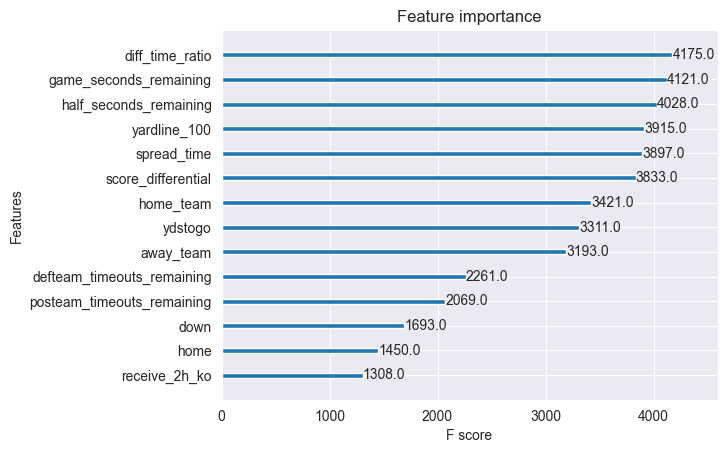

In [4]:
cross_validation.get_importance()

## Scoring The Model

Next, the model can be used to make predictions against test data, and binding the win probabilities to the test data frame:

In [5]:
cross_validation.get_scores()
cross_validation.test_data_predictions

,wp,label,game_id,home_team,away_team,season,receive_2h_ko,spread_time,home,half_seconds_remaining,game_seconds_remaining,diff_time_ratio,score_differential,down,ydstogo,yardline_100,posteam_timeouts_remaining,defteam_timeouts_remaining
0,0.246801,0,2022_01_BAL_NYJ,NYJ,BAL,2022,0,-6.471175,1,1796.0,3596.0,0.000000,0.0,1.0,10.0,78.0,3.0,3.0
1,0.271296,0,2022_01_BAL_NYJ,NYJ,BAL,2022,0,-6.279923,1,1769.0,3569.0,0.000000,0.0,1.0,10.0,59.0,3.0,3.0
2,0.258428,0,2022_01_BAL_NYJ,NYJ,BAL,2022,0,-6.252074,1,1765.0,3565.0,0.000000,0.0,2.0,10.0,59.0,3.0,3.0
3,0.244740,0,2022_01_BAL_NYJ,NYJ,BAL,2022,0,-6.087556,1,1741.0,3541.0,0.000000,0.0,3.0,5.0,54.0,3.0,3.0
4,0.227738,0,2022_01_BAL_NYJ,NYJ,BAL,2022,0,-6.033684,1,1733.0,3533.0,0.000000,0.0,4.0,15.0,64.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40941,0.799330,1,2022_22_KC_PHI,PHI,KC,2022,0,-0.020651,0,108.0,108.0,0.000000,0.0,1.0,10.0,11.0,2.0,1.0
40942,0.868566,1,2022_22_KC_PHI,PHI,KC,2022,0,-0.020377,0,96.0,96.0,0.000000,0.0,2.0,1.0,2.0,2.0,0.0
40943,0.875195,1,2022_22_KC_PHI,PHI,KC,2022,0,-0.019448,0,54.0,54.0,0.000000,0.0,3.0,6.0,7.0,1.0,0.0
40944,0.804326,1,2022_22_KC_PHI,PHI,KC,2022,0,-0.018541,0,11.0,11.0,0.000000,0.0,4.0,8.0,9.0,0.0,0.0


Finally, we can view the Model's log-loss and accuracy scores:

In [6]:
print(f"Log Loss: {cross_validation.logloss_score}")
print(f"Accuracy: {cross_validation.accuracy}")

Log Loss: 0.5203294471497274
Accuracy: 0.7427831778439896


And then plot the calibration data:

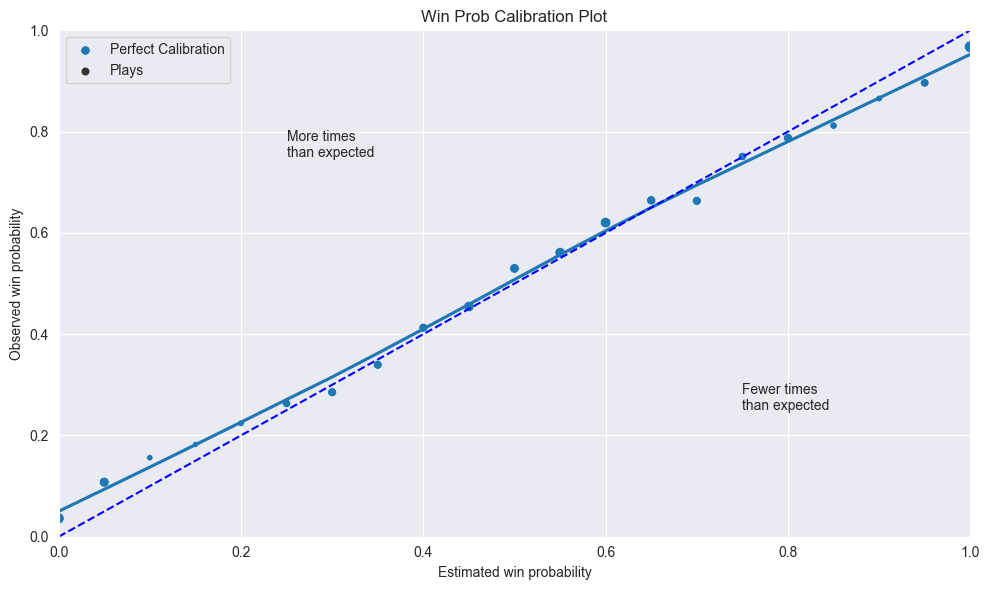

In [7]:
cross_validation.plot_calibration_score()

## Predicting the NFL 2023 Preseason Games

Now we are ready to begin predicting some upcoming games.  First, let's train the model with the entire data set:

In [8]:
wp_model = Model(pbp_df.data, train=True, maximize=True, test=False, train_season_subset=2023, num_splits=5,
                 init_points_factor=12, n_iter_factor=10, num_rounds=15000)

|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | -0.452    | 0.2666    | 0.2437    | 14.74     | 6.729     | 18.49     | 0.7881    |
| 2         | -0.4563   | 0.6777    | 0.07681   | 7.857     | 1.812     | 22.14     | 0.1752    |
| 3         | -0.4631   | 0.8244    | 0.1336    | 0.9554    | 10.46     | 47.29     | 0.5615    |
| 4         | -0.472    | 0.6262    | 0.1514    | 10.05     | 13.68     | 3.348     | 0.5338    |
| 5         | -0.4552   | 0.5253    | 0.1913    | 6.745     | 6.107     | 15.71     | 0.1007    |
| 6         | -0.4569   | 0.5498    | 0.1006    | 4.602     | 9.891     | 10.84     | 0.7681    |
| 7         | -0.4524   | 0.3098    | 0.1843    | 15.91     | 6.157     | 18.73     | 0.9952    |
| 8         | -0.4564   | 0.1       | 0.3       | 15.05     | 15.07     | 25.67     | 1.0       |
| 9         | -0.457

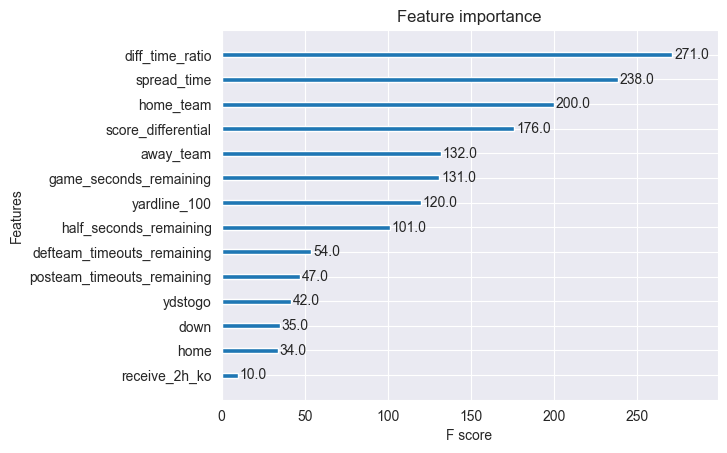

In [9]:
wp_model.get_importance()

Now let's run the predictions:

In [59]:
import pandas as pd
import numpy as np

games = ["2023_PRE_01_NYJ_CLE", "2023_PRE_02_HOU_NE", "2023_PRE_02_MIN_SEA", "2023_PRE_02_ATL_MIA",
         "2023_PRE_02_PIT_TB",
         "2023_PRE_02_GB_CIN", "2023_PRE_02_SF_DET", "2023_PRE_02_WAS_CLE", "2023_PRE_02_DEN_ARI",
         "2023_PRE_02_TEN_CHI", "2023_PRE_02_IND_BUF", "2023_PRE_02_NYJ_CAR", "2023_PRE_02_JAX_DAL",
         "2023_PRE_02_PHI_BAL", "2023_PRE_02_LAC_LA", "2023_PRE_02_KC_NO", "2023_PRE_02_SF_LV"]

home_teams = ["CLE", "NE", "SEA", "MIA", "TB", "CIN", "DET", "CLE", "ARI", "CHI", "BUF", "CAR", "DAL", "BAL", "LA",
              "NO", "LV"]
away_teams = ["NYJ", "HOU", "MIN", "ATL", "PIT", "GB", "SF", "WAS", "DEN", "TEN", "IND", "NYJ", "JAX", "PHI", "LAC",
              "KC", "SF"]

preseason_games = {
    "game_id": games,
    "home_team": home_teams,
    "away_team": away_teams,
    "game_seconds_remaining": [3600] * len(games),
    "half_seconds_remaining": [1800] * len(games),
    "yardline_100": [75] * len(games),
    "defteam_timeouts_remaining": [3] * len(games),
    "posteam_timeouts_remaining": [3] * len(games),
    "down": [1] * len(games),
    "ydstogo": [10] * len(games),
    "result": [0] * len(games),
    "posteam": ["BAMA"] * len(games),
    "defteam": ["BAMA"] * len(games),
    "qtr": [1] * len(games),
    "spread_line": [-2.5, 2.5, -2.5, 2.5, 1.5, 2.5, 3, 0, 3.5, -3.5, 2.5, 2.5, 2.5, -3.5, 1, -1.5, 3.5],
    "score_differential": [0] * len(games),
    "season": [2023] * len(games),
}

preseason_df = wp_model.predict(preseason_games)

winners = ["CLE", "HOU", "SEA", "ATL", "PIT", "GB", "DET", "WAS", "ARI", "CHI", "BUF", "NYJ", "JAX", "BAL", "LAC",
           "NO", "LV"]

preds = pd.concat([pd.DataFrame({"home_team_wp": preseason_df, "winner": winners}),
                   wp_model.test_data], axis=1)
preds["away_team_wp"] = 1 - preds["home_team_wp"]
results = preds[["game_id", "winner", "home_team", "home_team_wp", "away_team", "away_team_wp"]]

results['correct_prediction'] = np.where(
    (results['winner'] == results['home_team']) & (results['home_team_wp'] > results['away_team_wp']) | (
            results['winner'] == results['away_team']) & (results['away_team_wp'] > results['home_team_wp']), 1, 0)
results

C:\Users\Jonathan Bailey\AppData\Local\Temp\ipykernel_16336\2734519129.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['correct_prediction'] = np.where(


,game_id,winner,home_team,home_team_wp,away_team,away_team_wp,correct_prediction
0,2023_PRE_01_NYJ_CLE,CLE,CLE,0.589396,NYJ,0.410604,1
1,2023_PRE_02_HOU_NE,HOU,NE,0.431346,HOU,0.568654,1
2,2023_PRE_02_MIN_SEA,SEA,SEA,0.590303,MIN,0.409697,1
3,2023_PRE_02_ATL_MIA,ATL,MIA,0.416224,ATL,0.583776,1
4,2023_PRE_02_PIT_TB,PIT,TB,0.441740,PIT,0.558260,1
5,2023_PRE_02_GB_CIN,GB,CIN,0.397735,GB,0.602265,1
6,2023_PRE_02_SF_DET,DET,DET,0.379108,SF,0.620892,0
7,2023_PRE_02_WAS_CLE,WAS,CLE,0.589447,WAS,0.410553,0
8,2023_PRE_02_DEN_ARI,ARI,ARI,0.344658,DEN,0.655342,0
9,2023_PRE_02_TEN_CHI,CHI,CHI,0.695969,TEN,0.304031,1


And the accuracy:

In [60]:
accuracy = results['correct_prediction'].mean()
print(f"Accuracy: {round(accuracy * 100, 2)}%")

Accuracy: 70.59%


70% isn't bad for a small amount of boosting.

In [61]:
def favorite_implied_probability(team, odds):
    result = (-1 * odds) / ((-1 * odds) + 100)
    print(f"Favorite {team} likelihood of winning: {round(result * 100, 2)}%")
    return result


def favorite_wp_odds(team, wp):
    result = ((-1 * wp) / (1 - wp) * 100)
    print(f"Favorite {team} Expected Book Moneyline: {int(result)}")
    return result

In [49]:
favorite_implied_probability("PHI", -180)

Favorite PHI likelihood of winning: 64.29%


0.6428571428571429

In [62]:
favorite_wp_odds("PHI", .593)

Favorite PHI Expected Book Moneyline: -145


-145.7002457002457